#### Load The ENV Variables

In [1]:
#### Import ENV Variables

import os
from dotenv import load_dotenv
load_dotenv()

True

#### Import the Tools

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

## Using Arxiv Tool
arxiv_api_wrapper = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=arxiv_api_wrapper)

##Using WikiPedia Tool
wikipedia_api_wrapper = WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wikipedia = WikipediaQueryRun(api_wrapper=wikipedia_api_wrapper)

## Using Tavily Tool
tavily = TavilySearchResults()

C:\Users\hussa\AppData\Local\Temp\ipykernel_28748\1576376381.py:14: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


#### Create Custom ReAct Functions(Tools)

In [11]:
## Tool->01
def multiply(a:int,b:int)->int:
    """Multiply of A and B

    Args:
        a (int): First Number
        b (int): Second Number

    Returns:
        int: Result
    """
    return a*b

## Tool-->02
def add(a:int,b:int)->int:
    """Add of A and B

    Args:
        a (int): First Number
        b (int): Second Number

    Returns:
        int: Result
    """
    return a+b


#Tool-->03
def divide(a:int,b:int)->int:
    """Divide of A and B

    Args:
        a (int): First Number
        b (int): Second Number

    Returns:
        int: Result
    """
    return a/b

### Combine the Tools

In [12]:
tools = [arxiv,wikipedia,tavily,add,divide,multiply]
tools

[ArxivQueryRun(api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=2, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=500)),
 WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'd:\\LangGraphSeries\\module01\\venv\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=2, lang='en', load_all_available_meta=False, doc_content_chars_max=500)),
 TavilySearchResults(api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'))),
 <function __main__.add(a: int, b: int) -> int>,
 <function __main__.divide(a: int, b: int) -> int>,
 <function __main__.multiply(a: int, b: int) -> int>]

#### Call The LLM and Bind the Tools with LLM

In [ ]:
##Import The Model
from langchain_groq import ChatGroq
model = ChatGroq(model="llama-3.1-8b-instant")

##Bind the Tools and model using bind_tools() functions
tool_with_llm = model.bind_tools(tools)

In [19]:
from langchain_core.messages import HumanMessage,AIMessage
from pprint import pprint

tool_with_llm.invoke([HumanMessage(content=f"What is 2 multiply 2")])


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'zg9xjv97f', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 751, 'total_tokens': 770, 'completion_time': 0.03003912, 'completion_tokens_details': None, 'prompt_time': 0.061220671, 'prompt_tokens_details': None, 'queue_time': 0.055692849, 'total_time': 0.091259791}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b11ff-5819-7913-be92-0ff447e8c622-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 2}, 'id': 'zg9xjv97f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 751, 'output_tokens': 19, 'total_tokens': 770})

##### Graph Construction Phase

In [20]:
### Define the State Schema

from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [24]:
###Define the LLM Node
def calling_node(state:State):
    return {"messages":tool_with_llm.invoke(state["messages"])}


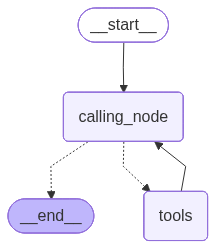

In [31]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Create a Graph
graph = StateGraph(State)

## Define the Nodes
graph.add_node("calling_node",calling_node)
graph.add_node("tools",ToolNode(tools))

## Define the edges
graph.add_edge(START,"calling_node")
graph.add_conditional_edges("calling_node",tools_condition)
graph.add_edge("tools","calling_node")

##Compile the Graph
graph_builder = graph.compile()

## Draw the Graph

display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [33]:
### Invoke the Process(Arxiv Call)
messages = graph_builder.invoke({"messages":HumanMessage(content="1706.03762")})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (n87y3s65k)
 Call ID: n87y3s65k
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base
================================== Ai Message ==================================
Tool Calls:
  wikipedia (qskyb2zvr)
 Call ID: qskyb2zvr
  Args:
    

In [34]:
### Invoke the Process(Wikipedia Call)
messages = graph_builder.invoke({"messages":HumanMessage(content="the free encyclopedia that anyone can edit309,329 active editors 7,104,379 articles in English")})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

the free encyclopedia that anyone can edit309,329 active editors 7,104,379 articles in English
================================== Ai Message ==================================
Tool Calls:
  wikipedia (p20d73a15)
 Call ID: p20d73a15
  Args:
    query: Wikipedia
================================= Tool Message =================================
Name: wikipedia

Page: Wikipedia
Summary: Wikipedia is a free online encyclopedia written and maintained by a community of volunteers, known as Wikipedians, through open collaboration and the wiki software MediaWiki. Founded by Jimmy Wales and Larry Sanger in 2001, Wikipedia has been hosted since 2003 by the Wikimedia Foundation, an American nonprofit organization funded mainly by donations from readers. Wikipedia is the largest and most-read reference work in history.
Initially available only in English, Wikipe
================================== Ai Message ============

#### Addition Tool Call

In [36]:
### Invoke the Process(Wikipedia Call)
messages = graph_builder.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news, add 5 plus 5 and then multiply by 10")})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news, add 5 plus 5 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (t33sn4xk9)
 Call ID: t33sn4xk9
  Args:
    query: Recent AI news
  add (221b942nd)
 Call ID: 221b942nd
  Args:
    a: 5
    b: 5
  add (4grzc2c5m)
 Call ID: 4grzc2c5m
  Args:
    a: 5
    b: 5
  multiply (qt0n0rv0t)
 Call ID: qt0n0rv0t
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "The latest AI news we announced in November - Google Blog", "url": "https://blog.google/technology/ai/google-ai-updates-november-2025/", "content": "# The latest AI news we announced in November\n\nDec 05, 2025\n\nHere’s a recap of some of our biggest AI updates from November, including the launch of Gemini 3, debut of Nano Ban

## Memory Saver----92

In [ ]:
### Specify the Thread

In [ ]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Create a Graph
graph = StateGraph(State)

## Define the Nodes
graph.add_node("calling_node",calling_node)
graph.add_node("tools",ToolNode(tools))

## Define the edges
graph.add_edge(START,"calling_node")
graph.add_conditional_edges("calling_node",tools_condition)
graph.add_edge("tools","calling_node")


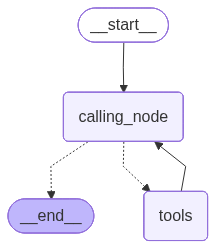

In [42]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

##Compile the Graph
graph_builder_with_memory = graph.compile(checkpointer=memory)

## Draw the Graph

display(Image(graph_builder_with_memory.get_graph().draw_mermaid_png()))

In [46]:
config = {"configurable":{"thread_id":"1"}}

messages = [HumanMessage(content="add 12 and 32")]

messages = graph_builder_with_memory.invoke(
    {"messages": messages},
    config=config
)

for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

add 12 and 32
================================== Ai Message ==================================
Tool Calls:
  add (zynx93cfe)
 Call ID: zynx93cfe
  Args:
    a: 12
    b: 32
================================= Tool Message =================================
Name: add

44
================================== Ai Message ==================================

The result of the function 'add' is 44.
